# Introduction to Variational Bayesian Methods
### October 19, 2017


#### This lecture borrows quite heavily from the wonderful exposition from Matthew B at Civis Analytics [here](https://www.civisanalytics.com/blog/variational-inference-ground/). Many thanks to him. 

The Bayesian Neural Network example (written by Thomas Wiecki) at the end of the lecture and can also be found in the pymc3 docs.



In Bayesian analysis, the most common strategy for computing posterior quantities is through Markov Chain Monte Carlo (MCMC). Despite recent advances in efficient sampling, MCMC methods still remain computationally intensive for more than a few thousand observations. A more scalable alternative to sampling is Variational Inference (VI), which re-frames the problem of computing the posterior distribution as a minimization of the Kullback-Leibler divergence between the true posterior and a member of some approximating family. 

In this lecture, we provide a basic overview of the VI framework as well as practical examples of its implementation using the Automatic Differentiation Variational Inference (ADVI) engine in PyMC3.

## Basics of Variational Bayesian Methods 


#### So, what's the bottleneck for Bayesian methods?

Suppose we have data $\boldsymbol{x}$ that is dependent on some latent variables $\theta$. The inferential problem is to compute the conditional density of the latent variables given the 
observations, $p(\theta | x)$. From this probability we can compute all sorts of useful quantities. Conditional probability gives us 

\begin{equation}
p(\theta|x) = \frac{p(\theta,x)}{p(x)}
\end{equation}

Where 
\begin{equation}
p(x) = \int p(\theta,x) d\theta,
\end{equation}

Which is the log density of the data, often called the "model evidence."
- This quantity is often unavailable in closed form and is the main source of computational headache, hearbreak, and frustration. 

## So what can we do instead??


1. Divide and Conquer approaches: See [this paper](https://arxiv.org/abs/1311.4780) or [this paper](https://arxiv.org/abs/1508.05880) for more details

2. One alternative approach is to build an approximation to the posterior $p(\theta|X)$ using some other distribution $q(\theta)$



## How do we go about approximating a distribution with another?

### Example: Approximating a Student's t with a gaussian 
Let's approximate a Students-t distribution with $\nu =3$  with a Gaussian distribution of some mean and variance.

One naive approach would be to build a set of test points and minimize the MSE between the $\log p(z)$ and $\log q(z)$. 

NOTE THIS IS NOT A GOOD WAY TO DO THIS. 

$$
{\hat \phi} = \underset{\phi}{{\rm arg\,min}} \frac{\sum_{i} q(\theta_{i};\phi)\left[\log q(\theta_{i};\phi) - \log p(\theta_{i})\right]^{2}}{\sum_{i} q(\theta_{i};\phi)}
$$

In [2]:
# load our packages:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import time
import scipy.special
import scipy.optimize
import scipy.stats
%matplotlib inline 
sns.set()

In [ ]:
### Okay let's define some functions

In [3]:
ν = 3
ν_NORM = scipy.special.gammaln((ν + 1)/2) - scipy.special.gammaln(ν/2) - 0.5 * np.log(ν*np.pi)
def logp(z):
    """log of students-t dist."""
    return -0.5 * (ν+1) * np.log(1 + z*z/ν) + ν_NORM

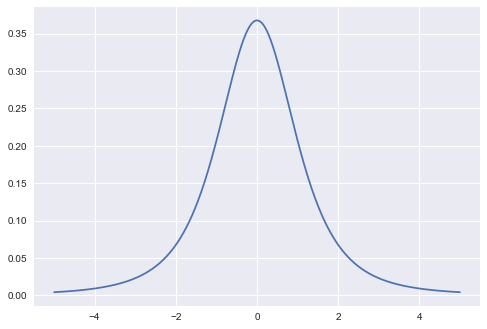

In [4]:
z = np.linspace(-5.0, 5.0, 1000)
pz = np.exp(logp(z))
plt.figure()
plt.plot(z, pz, label='p(z)')

## Let's define some functions to implement our routine for the approximation

Let's weight points that have more probability in the approximation $q(z)$, the idea being that points near the bulk of  $q(\theta)$ are more important to get right. OK. How do we pick $\theta_i$ ? Well, let's use the known distribution of  $q(\theta;\phi)$  at each step of the optimization to select a grid of points which sample the regions of highest probability density. Then we will optimize the objective function that we defined in terms of MSE. 

In [5]:
### Approximating Distro
def logq(θ, mu, lnsigma):
    """log of Gaussian parameterized by mean and log(sigma)"""
    sigma = np.exp(lnsigma)
    return -0.5 * ((θ - mu) / sigma) ** 2 - lnsigma - 0.5*np.log(2.0 * np.pi)
## Objective function and fit using scipy optimizer
def regression_vi(logp, n, mu_start, lnsigma_start, atol=1e-6):
    """use an optimizer for simple 1D VI"""
    phi_start = np.array([mu_start, lnsigma_start])
    
    # Objective function. Computes sum above on a grid.
    def obj(phi):
        _sigma = np.exp(phi[1])  # get sigma
        
        # This is the grid, factor of 10 is a random choice.
        z = np.linspace(phi[0] - 10.0*_sigma , phi[0] + 10.0*_sigma, n)

        # Build weights and differences.
        logqz = logq(z, phi[0], phi[1])
        w = np.exp(logqz)
        diff = logqz - logp(z)
        return np.sum(diff * diff * w) / np.sum(w)

    # Run the optimizer.
    opts = {'disp': True, 'maxiter': 5000, 'maxfev': 5000,
            'fatol': atol, 'xatol': 1e-8}
    phi_hat = scipy.optimize.minimize(obj, phi_start,
                                      method='Nelder-Mead',
                                      options=opts)
    print(phi_hat)
    return phi_hat['x'], phi_hat

phi_hat, res = regression_vi(logp, 100, 100.0, -100.0)

Optimization terminated successfully.
         Current function value: 0.034185
         Iterations: 107
         Function evaluations: 206
 final_simplex: (array([[ -3.31217268e-09,   1.39418201e-01],
       [  3.00982760e-09,   1.39418195e-01],
       [  5.89924420e-09,   1.39418199e-01]]), array([ 0.03418518,  0.03418518,  0.03418518]))
           fun: 0.03418517538400144
       message: 'Optimization terminated successfully.'
          nfev: 206
           nit: 107
        status: 0
       success: True
             x: array([ -3.31217268e-09,   1.39418201e-01])


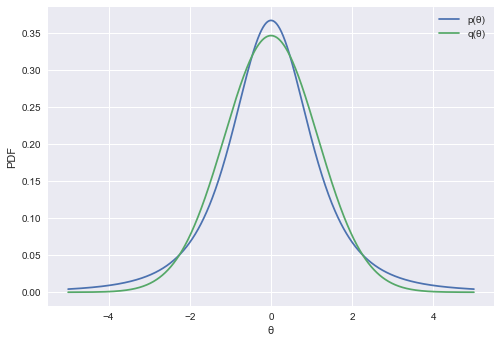

In [6]:
θ = np.linspace(-5.0, 5.0, 1000)
pθ = np.exp(logp(θ))
qθ = np.exp(logq(θ, phi_hat[0], phi_hat[1]))

plt.figure()
plt.plot(θ, pθ, label='p(θ)')
plt.plot(θ, qθ, label='q(θ)')
plt.xlabel('θ')
plt.ylabel('PDF')
plt.legend();

Perhaps a better solution would be to minimize the KL divergence between the approximating distribution and the truth:

$$
\begin{eqnarray*}
D_{\rm KL}\big(Q||P\big) &=& \int q(\theta) \log\frac{q(\theta)}{p(\theta)}d\theta\\
&=& \int q(\theta)\log q(\theta)d\theta - \int q(\theta)\log p(\theta)d\theta
\end{eqnarray*}
$$

In [7]:
def kl_vi(logp, n, mu_start, lnsigma_start):
    """vi with KL divergence"""
    phi_start = np.array([mu_start, lnsigma_start])
    
    # Objective function. Computes the KL div of q and p.
    def obj(phi):
        # This term is -\int q*log(q).
        # Also known as the differential entropy.
        # For a Gaussian, it can be computed exactly. 
        # See wikipedia or something.
        entropy = phi[1] + 0.5*np.log(2.0 * np.pi) + 0.5 ## 
        
        # now we need to evaluate the second integral in the KL divergence, let's numerically approximate it with a sum
        # This is the grid, factor of 20 is a random choice.
        _sigma = np.exp(phi[1])  # get sigma        
        θ = np.linspace(phi[0] - 20.0*_sigma , phi[0] + 20.0*_sigma, n) #number of grid points 
        dθ = θ[1] - θ[0]  # factor needed for numerical integral
        
        # This term is \int q*log(p)
        logqθ = logq(θ, phi[0], phi[1]) #just evaluate the variational density at each z on the grid and 
                                        # at the current value of phi
        qθ = np.exp(logqθ) # back transform
        return -entropy - np.sum(qθ * logp(θ) * dθ) #KL divergence for this phi
    # Pass this objective function to a scipy optimizer
    phi_hat = scipy.optimize.minimize(obj, phi_start,
                                      method='Nelder-Mead',
                                      options={'disp': True})
    print(phi_hat)
    return phi_hat['x'], phi_hat

phi_hat, res = kl_vi(logp, 10000, 1.0, 0.0)

Optimization terminated successfully.
         Current function value: 0.040695
         Iterations: 56
         Function evaluations: 108
 final_simplex: (array([[ -4.26771590e-06,   2.31270951e-01],
       [  5.19733032e-05,   2.31261077e-01],
       [  5.67321110e-05,   2.31314504e-01]]), array([ 0.04069546,  0.04069546,  0.04069546]))
           fun: 0.040695455334933017
       message: 'Optimization terminated successfully.'
          nfev: 108
           nit: 56
        status: 0
       success: True
             x: array([ -4.26771590e-06,   2.31270951e-01])


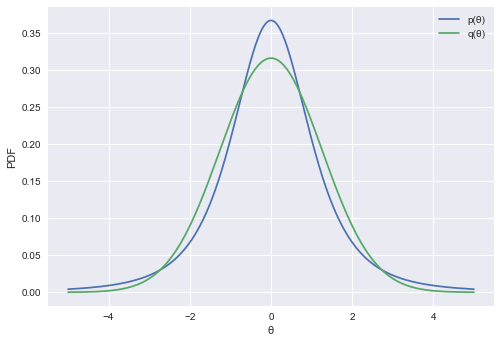

In [8]:
θ = np.linspace(-5.0, 5.0, 1000)
pθ = np.exp(logp(θ))
qθ = np.exp(logq(θ, phi_hat[0], phi_hat[1]))

plt.figure()
plt.plot(θ, pθ, label='p(θ)')
plt.plot(θ, qθ, label='q(θ)')
plt.xlabel('θ')
plt.ylabel('PDF')
plt.legend();


## Let's look at a more difficult pdf to approximate:
$$
 \log p(\theta) = 10^{3}\log \theta + \log(1-\theta) - c
$$

where the constant $c = Beta(10^3+1, 2)$.

A naive approach here would be to fit a rescaled Gaussian to match the support of $\theta$

In [9]:
def logq_unit(θ, mu, lnsigma):
    """log of Gaussian parameterized by mean and log(sigma)
    has unit integral over 0,1 
    and value zero outside of 0,1
    """
    val = np.zeros_like(θ)
    msk = (θ >= 1.0) | (θ <= 0.0)
    val[msk] = -np.inf
    if np.any(~msk):
        sigma = np.exp(lnsigma)
        a, b = (0.0 - mu) / sigma, (1.0 - mu) / sigma
        val[~msk] = scipy.stats.truncnorm.logpdf(θ[~msk], a=a, b=b, loc=mu, scale=sigma)
    
    return val

def logp_hard(θ, a=1e3, b=1):
    val = np.zeros_like(θ)
    msk = (θ >= 1.0) | (θ <= 0.0)
    val[msk] = -np.inf
    if np.any(~msk):
        val[~msk] = a * np.log(θ) + b * np.log(1.0 - θ) - scipy.special.betaln(a + 1.0, b + 1.0)
    return val

def kl_vi_unit(logp, n, mu_start, lnsigma_start, eps=1e-8):
    """vi with KL divergence over unit integral"""
    phi_start = np.array([mu_start, lnsigma_start])
    
    # Objective function. Computes the KL div of q and p.
    def obj(phi):
        # This term is -\int q*log(q).
        sigma = np.exp(phi[1])
        a, b = (0.0 - phi[0]) / sigma, (1.0 - phi[0]) / sigma
        entropy = scipy.stats.truncnorm.entropy(a=a, b=b, loc=phi[0], scale=sigma)

        # This is the grid, factor of 20 is a random choice.
        _sigma = np.exp(phi[1])  # get sigma        
        θ = np.linspace(eps, 1.0 - eps, n)
        dθ= θ[1] - θ[0]  # factor needed for numerical integral
        
        # This term is \int q*log(p)
        logqθ = logq_unit(θ, phi[0], phi[1])
        qθ = np.exp(logqθ)

        return -entropy - np.sum(qθ * logp(θ) * dθ)

    # Run the optimizer.
    phi_hat = scipy.optimize.minimize(obj, phi_start,
                                      method='Nelder-Mead',
                                      options={'disp': True, 'maxfev': 10000})
    print(phi_hat)
    return phi_hat['x'], phi_hat

phi_hat, res = kl_vi_unit(logp_hard, 10000, 0.0, 0.0)

/anaconda/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:4846: RuntimeWarning: divide by zero encountered in log
  self._logdelta = np.log(self._delta)
/anaconda/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:4850: RuntimeWarning: invalid value encountered in double_scalars
  return _norm_pdf(x) / self._delta


Optimization terminated successfully.
         Current function value: 0.145730
         Iterations: 231
         Function evaluations: 427
 final_simplex: (array([[ 0.9981397 , -6.63765288],
       [ 0.99813979, -6.63771762],
       [ 0.99813975, -6.63760831]]), array([ 0.14572997,  0.14572997,  0.14572997]))
           fun: 0.14572997442662317
       message: 'Optimization terminated successfully.'
          nfev: 427
           nit: 231
        status: 0
       success: True
             x: array([ 0.9981397 , -6.63765288])


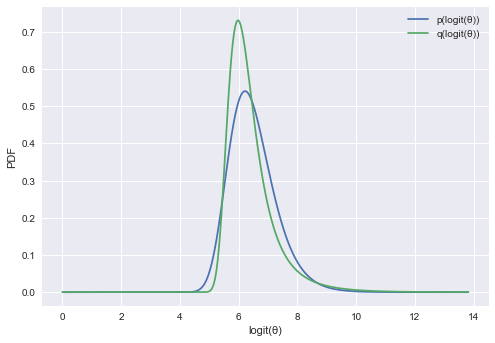

In [11]:
θ = np.linspace(0.5, 0.999999, 100000)
pθ = np.exp(logp_hard(θ))
qθ = np.exp(logq_unit(θ, phi_hat[0], phi_hat[1]))
dθ_dlogitθ = θ * (1.0 - θ)

plt.figure()
plt.plot(scipy.special.logit(θ), pθ * dθ_dlogitθ, label='p(logit(θ))')
plt.plot(scipy.special.logit(θ), qθ * dθ_dlogitθ, label='q(logit(θ))')
plt.xlabel('logit(θ)')
plt.ylabel('PDF')
plt.legend();

This looks a little weird and rescaling a gaussian to squeeze into the support of $\theta$ is not really a good solution if your parameters all have different supports.

Instead, let's do the reverse and transform the parameter space to that of a gaussian.
A transformation $T$ that maps $[0,1] \to R$ is the logit function. 
$$
T(\theta)=\zeta = {\rm logit}(\theta) = \log\left(\frac{\theta}{1-\theta}\right)\\
{\rm logit}^{-1}(\zeta) = {\rm sigmoid}(\zeta) = \frac{1}{1 + \exp\left(-\zeta\right)}\\
\frac{d{\rm sigmoid}(\zeta)}{d\zeta} = {\rm sigmoid}(\zeta) \left[1 - {\rm sigmoid}(\zeta)\right]\\
$$
and then our pdf in terms of the transformed parameter is given by
$$
\begin{eqnarray}
 \log p_{\zeta}(\zeta) &=& \log p({\rm sigmoid}(\zeta)) + \log\left|\frac{d{\rm sigmoid}(\zeta)}{d\zeta}\right|\\
&=& \log p({\rm sigmoid}(\zeta)) + \log {\rm sigmoid}(\zeta) + \log(1-{\rm sigmoid}(\zeta))\ .
\end{eqnarray}
$$

In [12]:
def logp_easy(logitθ, a=1e3, b=1):
    logabsjac = -1.0 * (np.log(1.0 + np.exp(-logitθ)) + np.log(1.0 + np.exp(logitθ)))
    return (-a * np.log(1.0 + np.exp(-logitθ)) - b * np.log(1.0 + np.exp(logitθ)) + 
            logabsjac - 
            scipy.special.betaln(a + 1.0, b + 1.0))

phi_hat, res = kl_vi(logp_easy, 10000, 1.0, 0.0)

Optimization terminated successfully.
         Current function value: 0.041045
         Iterations: 65
         Function evaluations: 126
 final_simplex: (array([[ 6.46509387, -0.34497398],
       [ 6.46518205, -0.34488247],
       [ 6.46511969, -0.34501641]]), array([ 0.04104499,  0.04104499,  0.041045  ]))
           fun: 0.041044993988631262
       message: 'Optimization terminated successfully.'
          nfev: 126
           nit: 65
        status: 0
       success: True
             x: array([ 6.46509387, -0.34497398])


## Let's see the plot

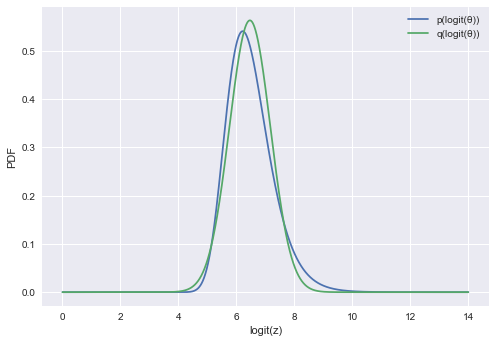

In [13]:
logitθ = np.linspace(0.0, 14.0, 100000)
plogitθ = np.exp(logp_easy(logitθ))
qlogitθ = np.exp(logq(logitθ, phi_hat[0], phi_hat[1]))

plt.figure()
plt.plot(logitθ, plogitθ, label='p(logit(θ))')
plt.plot(logitθ, qlogitθ, label='q(logit(θ))')
plt.xlabel('logit(z)')
plt.ylabel('PDF')
plt.legend();

## So what did we learn here? 

Re-casting $\theta$ to have the same support as a Gaussian makes for nice and easy minimization and fits much better than the other way around. 

# KEEP THIS IN MIND FOR LATER



#### This is all fine and dandy, but wait a second .....I thought we didn't know the posterior! How do we optimize the $D_{KL}$ when we don't have the true posterior??

Great question, hypothetical student! Let's revisit the KL divergence and see if we can employ some math trickery:

\begin{equation}
\phi^*=\arg\min_{\phi\in\Phi}D_{\rm KL}(q(\theta; \phi) || p(\theta|X))
\end{equation}


Now, we see that the KL divergence is given by

\begin{eqnarray}
D_{\rm KL}\big(Q||P\big)&=& \int q(\theta) \log\frac{q(\theta)}{p(\theta|x)}d\theta\\
&=& E_q\left[\log\frac{q(\theta)}{p(\theta|x)}\right]\\
&=&E_q[\log q(\theta)]-E_q[\log p(\theta|x)]\\
&=&-E_q[\log p(\theta,x)]+E_q[\log q(\theta)]+\log p(x)\\
&=& -ELBO +\log p(x)
\end{eqnarray}

We can see that the KL divergence is given by the sum of the ELBO and Model Evidence. To see why, let's revisit the model evidence. 

\begin{eqnarray*}
\log p(x)&=&\log\int p(x,\theta)d\theta\\
&=&\log\int p(x,\theta)\frac{q(\theta)}{q(\theta)}d\theta\\
&=&\log(E_{q}\left[\frac{p(x,\theta)}{q(\theta)}\right])\\
&\geq& E_q[\log p(x,\theta)]-E_q[\log q(\theta)].
\end{eqnarray*}

What this implies for a computational solution is that minimizing the KL divergence is accomplished by maximizing the evidence lower bound.



## [Automatic Differentiation Variational Inference](https://arxiv.org/abs/1603.00788): A Tale of Two Transformations
With ease of computation in mind, Kucukelbir et. al. 2015 developed a way to perform VI automatically. Without going into too much detail (see reference for details), the authors proposed transforming the problem in a series of steps:

1. Specify the joint model, $p(x,\theta)$
2. Transform model into surrogate containing unconstrained real-valued latent variables, $\zeta$. $p(x,\theta) \to p(x,\zeta)$
    - Variational inference is then performed on the transformed model. New objective: 
    
$$
\begin{equation}
\phi^*=\arg\min_{\phi\in\Phi} KL(q(\zeta; \phi)||p(\zeta|x))
\end{equation}
$$

all latent variables are defined on the same space. ADVI can now use a single variational family for all models
 
3. ADVI recasts the gradient of the variational objective function as an expectation over $q$. This allows for the use of Monte Carlo integration to perform the optimization
4. Next, the framework transforms the problem again and re-casts the gradient in terms of a standard Gaussian distribution. This makes MC integration very efficient since sampling is done from $N(0,1)$
5. Compute noisy gradients to optimize the objective. 


## Let's get a little bit of a feel for how this happens 

Remember, we're first going to transform all of our parameters to have the same support in $R^k$. We next need to optimize the KL divergence on the transformed space (like in the sigmoid transformation above). 

To accomplish this, we need to optimize the ELBO for the transformed objective. Our objective function for the transformed variables is now given by the ELBO of the transformation:

$$
ELBO(\phi) = E_{q(\zeta;\phi)}\left[\log p(x,T^{-1}(\zeta))+\log|\det J_{T^{-1}}(\zeta)|\right] - E_q[\log q(\zeta;\phi)]
$$




This notation is starting to get a litle hairy, so let's return to basics. Remember, the first expectation is just an expectation over a joint likelihood in terms of the approximating variational distribution.  

$$
\int q(z)\log p(x,T^{-1}(\zeta))|\det J_{T^{-1}}(\zeta)| dz \approx \frac{1}{n}\sum_i \log p(x|\zeta_{i})p(\zeta_{i})
$$

Problem is, we can't differentiate this MC integration with respect to the variational parameters (since they parameterize the distribution from which we draw $\zeta_i$). So we need to transform one more time so that the expectation is in terms of a standard normal (this is called elliptic standardization), and them perform MC integration with a draw from a standard normal. 
$$
\int q(\zeta) \log p(x|\zeta)p(\zeta) d\zeta = \int N(\zeta) \log p(x|\zeta\sigma+\mu)p(\zeta\sigma+\mu) dz \approx \frac{1}{n}\sum_i \log p(x|\zeta_{i}\sigma+\mu)p(\zeta_{i}\sigma+\mu)\ .
$$

Now, since this integral is explicitly in terms of the variational parameters, we can optimize our objective. 

## Above is something we can take derivatives of using a computational backend. We'll use pymc3 in a moment. But let's return to our weird pdf.

We can now implement a really crude version of advi on our weird pdf:

In [15]:
def dlogp_easy_dζ(ζ):
    θ = scipy.special.expit(ζ)
    return (1e3 + 1.0) * (1.0 - θ) - 2 * θ

def kl_vi_with_sgd(dlogp, mu, lnsigma, rng, n_iter=100000, n_draw=1, eta=5e-4, eta_decay=5e-5):
    for i in range(n_iter):
        # Draw the points and convert back to draws from the variational approximation.
        ζ_standard = rng.normal(size=n_draw)
        sigma = np.exp(lnsigma)
        ζ = ζ_standard*sigma + mu
        
        # Compute the derivs.
        dkl_dmu = -np.mean(dlogp(ζ))
        dkl_dlnsigma = -np.mean(dlogp(ζ) * ζ_standard * sigma) - 1
        
        # Now do SGD with the KL divergence.
        lnsigma -= dkl_dlnsigma * eta
        mu -= dkl_dmu * eta
        
        # Decay the learning rate.
        eta *= 1.0 - eta_decay
        
        if i % (n_iter // 25) == 0 or i == n_iter - 1:
            print("iter, mu, lnsigma: % 7d|% 10.4e|% 10.4e" % 
                  (i, mu, lnsigma))
        
    return np.array([mu, lnsigma])

rng = np.random.RandomState(seed=5678)
phi_hat = kl_vi_with_sgd(dlogp_easy_dζ, 0.0, 0.0, rng)

iter, mu, lnsigma:       0| 3.3518e-01|-2.3741e-01
iter, mu, lnsigma:    4000| 6.3373e+00|-4.7391e-01
iter, mu, lnsigma:    8000| 6.4378e+00|-3.4406e-01
iter, mu, lnsigma:   12000| 6.4592e+00|-3.5437e-01
iter, mu, lnsigma:   16000| 6.4571e+00|-3.4403e-01
iter, mu, lnsigma:   20000| 6.4656e+00|-3.5536e-01
iter, mu, lnsigma:   24000| 6.4663e+00|-3.6306e-01
iter, mu, lnsigma:   28000| 6.4572e+00|-3.5847e-01
iter, mu, lnsigma:   32000| 6.4657e+00|-3.5701e-01
iter, mu, lnsigma:   36000| 6.4643e+00|-3.5113e-01
iter, mu, lnsigma:   40000| 6.4556e+00|-3.4125e-01
iter, mu, lnsigma:   44000| 6.4647e+00|-3.4658e-01
iter, mu, lnsigma:   48000| 6.4712e+00|-3.4985e-01
iter, mu, lnsigma:   52000| 6.4660e+00|-3.4201e-01
iter, mu, lnsigma:   56000| 6.4645e+00|-3.4355e-01
iter, mu, lnsigma:   60000| 6.4649e+00|-3.4346e-01
iter, mu, lnsigma:   64000| 6.4657e+00|-3.4193e-01
iter, mu, lnsigma:   68000| 6.4624e+00|-3.4012e-01
iter, mu, lnsigma:   72000| 6.4602e+00|-3.3670e-01
iter, mu, lnsigma:   76000| 6.4

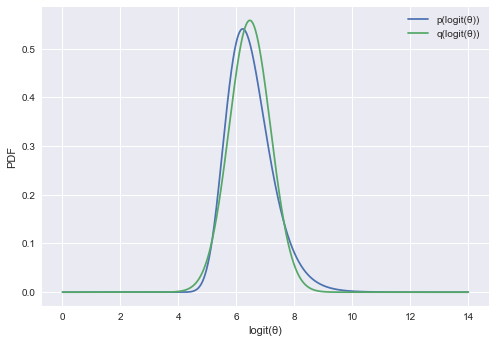

In [16]:
logitθ = np.linspace(0.0, 14.0, 100000)
plogitθ = np.exp(logp_easy(logitθ))
qlogitθ = np.exp(logq(logitθ, phi_hat[0], phi_hat[1]))

plt.figure()
plt.plot(logitθ, plogitθ, label='p(logit(θ))')
plt.plot(logitθ, qlogitθ, label='q(logit(θ))')
plt.xlabel('logit(θ)')
plt.ylabel('PDF')
plt.legend();

But we certainly don't want to have to compute derivatives all by hand!

## Variational Inference in PyMC3

Theano, PyTorch, and Tensorflow are all computational backends to compute derivatives symbolically so we don't have to hand code anything. PyMC3 uses Theano which is what we will be working in.






In [17]:
# Now create toy data
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import theano
size = 50
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

Okay let's plot this:

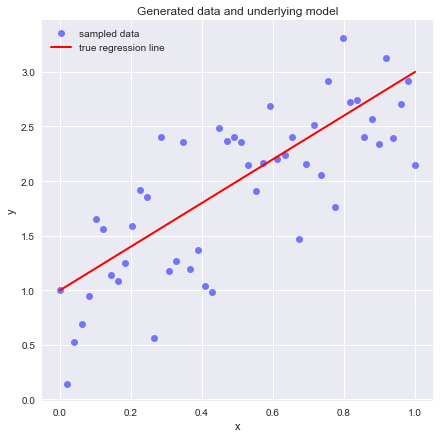

In [18]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
#plt.plot(x, y,"bo", label='sampled data', alpha =0.01)
ax.plot(x, y,"bo", label='sampled data',alpha =0.5)
ax.plot(x, true_regression_line, label='true regression line', lw=2.,color = "red")
plt.legend(loc=0);

In [19]:
# Some very basic pymc3 coding:
with pm.Model() as model:
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sd=20)
    x_coeff = pm.Normal('x', 0, sd=20)
    # Define likelihood
    likelihood = pm.Normal('y', mu=intercept + x_coeff * x,
                        sd=sigma, observed=y)
    trace = pm.sample(3000, njobs=2) 


 94%|█████████▍| 3299/3500 [00:07<00:00, 299.91it/s]/Users/schluetd/Desktop/pymc3/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.879271540824, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 3500/3500 [00:08<00:00, 408.72it/s]


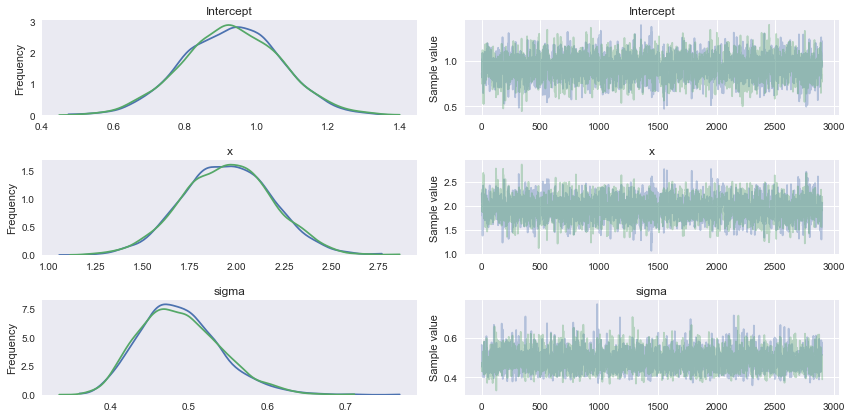

In [20]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace[100:])
plt.tight_layout();

### Okay, cool now for the sake of demonstration, let's ramp up the number of observations and see how to perform minibatch ADVI in pymc3.

In [21]:
size = 500000
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

### First, we need to set up a framework where we minibatch the data:


In [23]:
batchsize = 5000
x_minibatch = pm.Minibatch(x, batch_size=batchsize)
y_minibatch = pm.Minibatch(y, batch_size=batchsize)

### We now just need to make a few minor adjustments to our model to accomodate these new tensors.

In [24]:
# 
with pm.Model() as model_vi: # 
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sd=20)
    x_coeff = pm.Normal('x', 0, sd=20)
    #define model mean in terms of minibatch tensor
    mean = intercept + x_coeff * x_minibatch
    # Define likelihood
    likelihood = pm.Normal('likelihood', mu = mean, sd = sigma, observed=y_minibatch, total_size = len(y))

In [25]:
with model_vi:
    approx = pm.variational.fit(n=20000, method="advi")#, obj_optimizer =pm.adagrad(learning_rate=0.1))

Average Loss = 3.6769e+05: 100%|██████████| 20000/20000 [01:48<00:00, 184.19it/s]


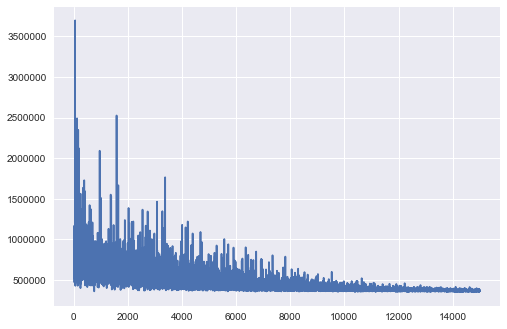

In [27]:
plt.plot(approx.hist[5000:])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a2ddd30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1175c0e10>]], dtype=object)

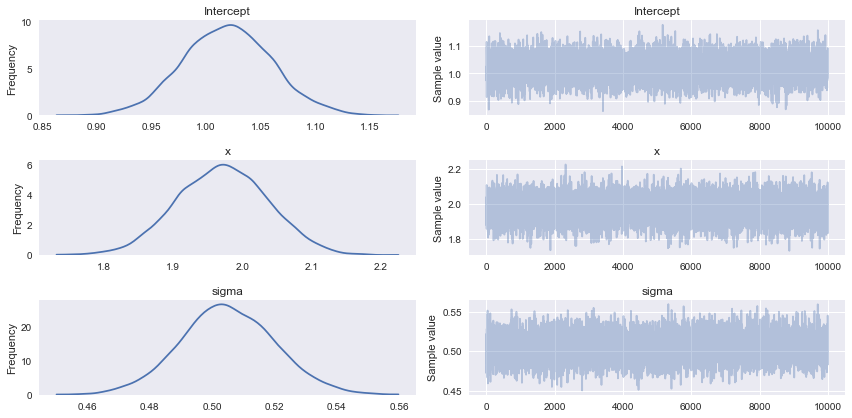

In [28]:
trace_vi = approx.sample(10000) 
pm.traceplot(trace_vi)

Here, `trace_vi` acts exactly like a trace from mcmc. 

### Exercise: Bayesian Neural Network

For an in depth introduction to Neural Networks, see Prof. Fonnesbeck's notebook [here](https://github.com/fonnesbeck/Bios8366/blob/master/notebooks/Section6_7-Neural-Networks.ipynb)

In [29]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [30]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

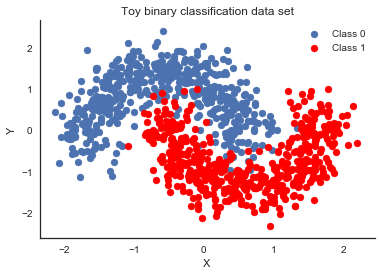

In [31]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

We first define the model. Since, PyMC3 uses Theano as a back end, functions need to be compiled first. 

In [32]:
# Trick: Turn inputs and outputs into shared variables.
# It's still the same thing, but we can later change the values of the shared variable
# (to switch in the test-data later) and pymc3 will just use the new data.
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

n_hidden = 5

# Initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
init_out = np.random.randn(n_hidden).astype(floatX)

with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1,
                             shape=(X.shape[1], n_hidden),
                             testval=init_1)

    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1,
                            shape=(n_hidden, n_hidden),
                            testval=init_2)

    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                              shape=(n_hidden,),
                              testval=init_out)

    # Build neural-network using tanh activation function
    act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                     weights_in_1))
    act_2 = pm.math.tanh(pm.math.dot(act_1,
                                     weights_1_2))
    act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                          weights_2_out))

    # Binary classification -> Bernoulli likelihood
    out = pm.Bernoulli('out',
                       act_out,
                       observed=ann_output)

In [41]:
with neural_network:
    advi_approx = pm.fit(n=10000,method ='advi', obj_optimizer=pm.adam(learning_rate=0.01))

Average Loss = 125.01: 100%|██████████| 10000/10000 [00:04<00:00, 2396.64it/s]


In [44]:
trace = advi_approx.sample(2000)

We can see the optimization course by plotting the ELBO values over time.

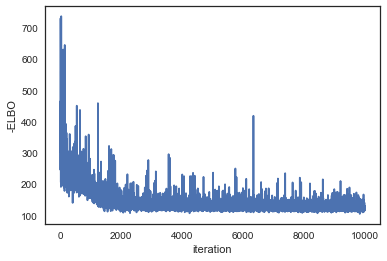

In [43]:
plt.plot(advi_approx.hist)
plt.ylabel('-ELBO')
plt.xlabel('iteration')

Of course, we can predict new values...

In [45]:
# Replace shared variables with testing set
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

100%|██████████| 500/500 [00:03<00:00, 159.87it/s]


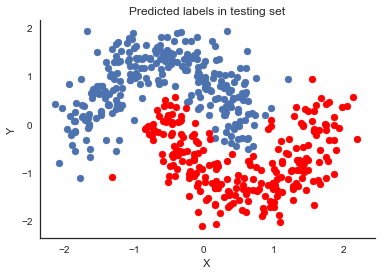

In [46]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [47]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))


Accuracy = 96.8%


In [48]:
grid = np.mgrid[-3:3:100j,-3:3:100j].astype(floatX)
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [49]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)


100%|██████████| 500/500 [00:02<00:00, 216.73it/s]


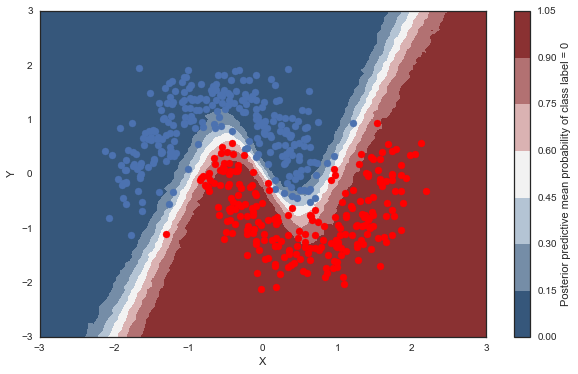

In [50]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

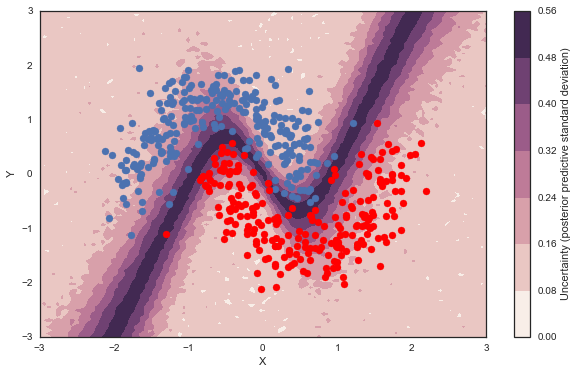

In [51]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

### References: 
    1. Variational Inference from the ground up: https://www.civisanalytics.com/blog/variational-inference-ground/
    2. [Automatic Differentiation Variational Inference. Kucukelbir, A., Tran D., Ranganath, R., Gelman, A., and Blei, D. M. (2016)](https://arxiv.org/abs/1603.00788)
    2. [Variational Inference: A Review for Statisticians, David M. Blei, Alp Kucukelbir, Jon D. McAuliffe (2016)] (https://arxiv.org/abs/1601.00670)